Copyright 2022 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This colab accompanies the paper 'Role of Human-AI Interaction in Selective Prediction' in AAAI 2022 by Bondi et al.

In [12]:
import copy
import enum
from typing import List, Optional, Sequence, Tuple, Mapping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats
import tempfile

In [13]:
def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Loads the human data.
  
  Returns:
  A tuple of (participant_df, imagewise_df), where:
    participant_df: Each row contains data averaged from a participant's
      responses to 5 images with the same metadata. That is, those 5 images had
      the same ground truth label, model prediction, messaging condition, and
      status of whether the model was correct or not. As the dataset presented
      to human participants was balanced across these conditions, there are 16
      rows per participant id, making a total of 80 images.
      Columns:
        participant_id: Which participant made the response (anonymised).
        accuracy: Participant accuracy over 5 images in the same category.
        preds: Whether the model predicted an animal was present.
        labels: Ground truth labels. 1 = animal present; 0 = no animal present.
        preds_msg: Whether a prediction message was shown with the image.
        defer_msg: Whether a deferral message was shown with the image.
        model_correct: Whether the model correctly classified this image.
    imagewise_df: Each row is a unique image that was evaluated by participants.
      Columns:
        image_name: Unique image identifier.
        label: Ground truth labels. 1 = animal present; 0 = no animal present.
        model_score: Logits output from the model (threshold=0.1931999921798706).
        model_prediction: Whether model predicted an animal present.
        human_likert: Likert ratings from human participants.
        human_correct: Whether human participants correctly classified the image.
        human_accuracy: Average of human_correct scores across all ratings.
        condition_form_X: Which of the four conditions (NM, DO, PO, BM) the
          image was used for in a given randomisation.
        human_ratings_form_X: Human likert ratings when image presented in a
          given randomisation.
  """
  f = tempfile.NamedTemporaryFile()
  !gsutil cp "gs://dm-hai-selective-prediction/participant_df.pd" {f.name}
  with open(f.name, 'rb') as file:
    participant_df = pd.read_parquet(file)

  f = tempfile.NamedTemporaryFile()
  !gsutil cp "gs://dm-hai-selective-prediction/imagewise_df.pd" {f.name}
  with open(f.name, 'rb') as file:
    imagewise_df = pd.read_parquet(file)     

  return (participant_df, imagewise_df)


In [14]:
participant_df, imagewise_df = load_data()
participant_df.head(10)

Copying gs://dm-hai-selective-prediction/participant_df.pd...
/ [1 files][  7.9 KiB/  7.9 KiB]                                                
Operation completed over 1 objects/7.9 KiB.                                      
Copying gs://dm-hai-selective-prediction/imagewise_df.pd...
/ [1 files][ 29.6 KiB/ 29.6 KiB]                                                
Operation completed over 1 objects/29.6 KiB.                                     


,participant_id,accuracy,preds,labels,preds_msg,defer_msg,model_correct
0,2,0.6,0,0,0,0,1
1,2,0.6,0,0,0,1,1
2,2,0.8,0,0,1,0,1
3,2,1.0,0,0,1,1,1
4,2,0.0,0,1,0,0,0
5,2,0.6,0,1,0,1,0
6,2,0.4,0,1,1,0,0
7,2,0.8,0,1,1,1,0
8,2,0.4,1,0,0,0,0
9,2,0.8,1,0,0,1,0


In [15]:
imagewise_df.head(10)

,image_name,label,model_score,model_prediction,human_likert,human_correct,human_accuracy,condition_form_0,condition_form_1,condition_form_2,condition_form_3,human_ratings_form_0,human_ratings_form_1,human_ratings_form_2,human_ratings_form_3
0,S1/E06/E06_R3/S1_E06_R3_PICT0045,1,0.100182,0,"[5, 1, 3, 3, 4, 5, 5, 1, 5, 4, 1, 4, 1, 4, 1, ...","[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, ...",26.767677,DO,NM,NM,PO,"[5.0, 1.0, 3.0, 3.0, 4.0, 5.0, 5.0, 1.0, 5.0, ...","[1.0, 1.0, 2.0, 5.0, 1.0, 2.0, 1.0, 2.0, 5.0, ...","[1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 4.0, 1.0, 2.0, ...","[2.0, 3.0, 2.0, 2.0, 2.0, 5.0, 2.0, 1.0, 2.0, ..."
1,S1/G02/G02_R4/S1_G02_R4_PICT0088,0,0.116808,0,"[1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",96.969697,NM,PO,PO,NM,"[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, ...","[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ..."
2,S1/F09/F09_R2/S1_F09_R2_PICT1369,0,0.330209,1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.515152,NM,PO,NM,PO,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
3,S1/G10/G10_R1/S1_G10_R1_PICT0367,0,0.115413,0,"[5, 4, 4, 1, 4, 5, 5, 1, 5, 4, 1, 4, 5, 2, 5, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",22.727273,DO,PO,PO,PO,"[5.0, 4.0, 4.0, 1.0, 4.0, 5.0, 5.0, 1.0, 5.0, ...","[5.0, 1.0, 4.0, 4.0, 5.0, 1.0, 4.0, 4.0, 1.0, ...","[2.0, 3.0, 4.0, 3.0, 2.0, 5.0, 5.0, 5.0, 4.0, ...","[5.0, 4.0, 5.0, 1.0, 5.0, 4.0, 5.0, 5.0, 2.0, ..."
4,S1/F02/F02_R4/S1_F02_R4_PICT1790,1,0.268470,1,"[1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 2, 1, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.525253,DO,BM,NM,DO,"[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0, 1.0, 3.0, ...","[1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, ...","[1.0, 1.0, 2.0, 5.0, 1.0, 1.0, 1.0, 1.0, 3.0, ...","[1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, ..."
5,S1/I02/I02_R1/S1_I02_R1_PICT1954,1,0.115198,0,"[1, 1, 5, 1, 5, 3, 3, 1, 3, 3, 1, 2, 3, 3, 1, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48.484848,PO,BM,DO,DO,"[1.0, 1.0, 5.0, 1.0, 5.0, 3.0, 3.0, 1.0, 3.0, ...","[5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 1.0, 5.0, 1.0, ...","[2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 5.0, 5.0, 3.0, ...","[3.0, 3.0, 5.0, 5.0, 3.0, 1.0, 5.0, 4.0, 5.0, ..."
6,S1/H01/H01_R1/S1_H01_R1_PICT2586,0,0.108003,0,"[1, 4, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 4, 2, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...",80.303030,DO,NM,NM,PO,"[1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, ...","[1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[1.0, 3.0, 5.0, 1.0, 2.0, 3.0, 3.0, 1.0, 1.0, ...","[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,S1/I07/I07_R1/S1_I07_R1_PICT1376,1,0.268022,1,"[5, 1, 4, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",46.464646,NM,PO,PO,NM,"[5.0, 1.0, 4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, ...","[5.0, 1.0, 3.0, 1.0, 5.0, 4.0, 1.0, 4.0, 4.0, ...","[2.0, 2.0, 5.0, 3.0, 4.0, 4.0, 3.0, 1.0, 4.0, ...","[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0, 1.0, ..."
8,S1/H11/H11_R1/S1_H11_R1_PICT5454,0,0.105132,0,"[1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 1, 1, 3, 2, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",85.353535,NM,PO,BM,DO,"[1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 5.0, 1.0, 2.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 4.0, 1.0, 1.0, ...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ..."
9,S1/I08/I08_R1/S1_I08_R1_PICT0142,0,0.295539,1,"[3, 1, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 2, 2, 1, ...","[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...",76.262626,BM,DO,PO,DO,"[3.0, 1.0, 2.0, 4.0, 2.0, 5.0, 3.0, 1.0, 3.0, ...","[1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...","[2.0, 2.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0

In [16]:
#@title Plotting functions and utils

# Model score above which the model classifies there being an animal present.
MODEL_DECISION_THRESHOLD = 0.1931999921798706

# Plotting settings.
COLOURS = ['#687566', '#4464AD', '#F5843D']
_BAR_KWARGS = {'width': 0.7, 'zorder': 1, 'edgecolor': 'k', 'linewidth': 1}
_ERRORBAR_KWARGS = {'zorder': 2, 'fmt': 'None', 'linewidth': 2, 'ecolor': 'k'}

CORRECTNESS_LABELS = ['1', '0']  # 1 is Correct, 0 is incorrect.


def correctness_to_accuracy(correctness: Sequence[int]) -> float:
  """Converts binary correctness scores to percentage accuracy."""
  return sum(correctness)*100 / float(len(correctness))


def get_95confidence(data: np.ndarray) -> None:
  """Returns the error magnitude for 95% confidence interval."""
  return (data.std() / np.sqrt(data.shape[0])) * 1.96


def likert_to_confidence(likerts: Sequence[int]) -> np.ndarray:
  """Converts likert values to a confidence score."""
  confidence = []
  mapping = {1: 2, 2: 1, 3: 0, 4: 1, 5: 2}  # Maps likert to a confidence value.
  for likert in likerts:
    confidence.append(mapping[likert])
  return np.mean(confidence)


def likert_to_correctness(
    likerts: Sequence[int],
    ground_truth: np.ndarray,
) -> List[int]:
  """Converts likert values to binary correctness scores.

  'Correct' means the human classified the image correctly, regardless of
  confidence in that classification. An 'unsure' Likert value of 3, is mapped
  to `incorrect`.

  Args:
    likerts: An array of integer Likert values in the set {1,2,3,4,5}, which
      correspond to confidence judgements in a classification decision. A value
      of 5 means high confidence that an animal was in the image and a value of
      1 means high confidence that an animal was not in the image.
    ground_truth: An array of binary labels indicating whether an animal was
      present in an image (=1) or not (=0).
  Returns:
    A list of binary correctness labels.
  """
  incorrect_label, correct_label = (0, 1)
  threshold_likert = 3
  correct = []
  for likert in likerts:
    if likert == threshold_likert:  # likert==3 is always incorrect
      correct.append(incorrect_label)
    elif ground_truth:
      # There is an animal in the image.
      if likert > threshold_likert:
        correct.append(correct_label)  # True positive.
      else:
        correct.append(incorrect_label)  # False negative.
    else:
      # There is not an image in the image.
      if likert > threshold_likert:
        correct.append(incorrect_label)  # True negative.
      else:
        correct.append(correct_label)  # False positive.
  return correct


def model_score_to_confidence(
    scores: np.ndarray,
    threshold: float,
) -> np.ndarray:
  """Converts model scores to a confidence metric."""
  return np.abs(scores - threshold)


def compute_imagewise_accuracy(
    data: pd.DataFrame,
    conditions: Sequence[str],
) -> Mapping[str, np.ndarray]:
  """Computes human accuracy on each image, when the model is correct/incorrect.

  Restricts data to specific testing conditions.
  Args:
    data: Imagewise dataframe.
    conditions: Only data from images presented in these named conditions will
      be included in the analysis.
  Returns:
    Human accuracy on each image for images examined under the specified
    conditions. Output as a dictionary which divides accuracy into images for
    which the model was correct or not.
  """
  accuracy = {'model_correct': [], 'model_incorrect': []}
  for _, row in data.iterrows():
    images_found = False
    human_labels = []
    if row['condition_form_0'] in conditions:
      human_labels.append(row['human_ratings_form_0'])
      images_found = True
    if row['condition_form_1'] in conditions:
      human_labels.append(row['human_ratings_form_1'])
      images_found = True
    if row['condition_form_2'] in conditions:
      human_labels.append(row['human_ratings_form_2'])
      images_found = True
    if row['condition_form_3'] in conditions:
      human_labels.append(row['human_ratings_form_3'])
      images_found = True

    if images_found:
      # Human accuracy.
      flat_labels = []
      for sublist in human_labels:
        for element in sublist:
          flat_labels.append(element)
      human_correct = likert_to_correctness(flat_labels, row['label'])
      human_accuracy = correctness_to_accuracy(human_correct)

      # Model performance.
      model_answer = (1 if row['model_score'] > MODEL_DECISION_THRESHOLD else 0)
      model_correct = (1 if model_answer == row['label'] else 0)

      if model_correct:
        accuracy['model_correct'].append(human_accuracy)
      else:
        accuracy['model_incorrect'].append(human_accuracy)

  return {key: np.asarray(value) for key, value in accuracy.items()}


def compute_human_and_model_scores(
    data: pd.DataFrame,
    conditions: Sequence[str],
) -> Tuple[List[float], List[float]]:
  """Computes human likert scores and model scores for each image.

  Restricts data to specific testing conditions.
  Args:
    data: Imagewise dataframe.
    conditions: Only data from images presented in these named conditions will
      be included in the analysis.

  Returns:
    Mean human likert scores and model scores on each image for the given
    conditions.
  """
  mean_likerts = []
  model_scores = []
  for _, row in data.iterrows():
    image_found = False
    human_labels = []
    if row['condition_form_0'] in conditions:
      human_labels.append(row['human_ratings_form_0'])
      image_found = True
    if row['condition_form_1'] in conditions:
      human_labels.append(row['human_ratings_form_1'])
      image_found = True
    if row['condition_form_2'] in conditions:
      human_labels.append(row['human_ratings_form_2'])
      image_found = True
    if row['condition_form_3'] in conditions:
      human_labels.append(row['human_ratings_form_3'])
      image_found = True

    if image_found:
      flat_labels = []
      for sublist in human_labels:
        for element in sublist:
          flat_labels.append(element)
      mean_likerts.append(np.mean(flat_labels))
      model_scores.append(row['model_score'])

  return mean_likerts, model_scores


def figure_5(
    *,
    means: Sequence[np.ndarray],
    errors: Sequence[np.ndarray],
    labels: Sequence['str'],
    ax: plt.Axes,
    colours: Tuple[str],
    ylim: Tuple[float, float] = (45.0, 70.0),
) -> None:
  """Plots figure 5: Human accuracy in each of the four conditions.

  Args:
    means: Mean human accuracy for each of the four conditions.
    errors: Error magnitudes for each of our four conditions.
    labels: Labels for the x-axis.
    ax: Axes on which to plot.
    colours: Three colours for plotting with.
    ylim: y-axis limits.
  """
  xlabel_locations = np.arange(len(labels))
  handles = []
  for xlabel_location, mean, error in zip(xlabel_locations, means, errors):
    h = ax.bar(xlabel_location, 100.*mean, color=colours[0], **_BAR_KWARGS)
    handles.append(h)
    ax.errorbar(xlabel_location, 100.*mean, yerr=100.*error, **_ERRORBAR_KWARGS)
  ax.set_ylim(ylim)
  ax.set_xlim([-0.6, 3.6])
  ax.set_xticks(xlabel_locations)
  ax.set_xticklabels(labels)
  ax.hlines(50, -1, 5, color='darkgrey', linestyles='dashed', zorder=6)
  ax.set_ylabel('Human accuracy (%)')
  ax.set_xlabel('Messaging condition')


def figure_6(
    *,
    all_conformity: np.ndarray,
    sure_conformity: np.ndarray,
    unsure_conformity: np.ndarray,
    colours: Sequence[str],
    ) -> None:
  """Plots figure 6: Conformity analysis.

  We measure conformity as the difference in human-model agreement when the
  humans have no access to the model prediction, vs. when they do. The relative
  increase in agreement in the latter condition indicates the extent to which
  people integrate this information into their own judgments. Here we only
  investigate the conditions with no deferral message (NM and PO), to avoid any
  additional complicating factors of this message.

  As previous research indicates that people are more likely to conform when
  they are less confident in their own judgments, we additionally investigate
  conformity when the human judgments are low vs. high confidence.

  We report a statistically significant difference consistent with prior
  research, showing that conformity is higher when human confidence is low.

  Args:
    all_conformity: Array of all conformity scores regardless of confidence.
    sure_conformity: High confidence conformity scores.
    unsure_conformity: Low confidence conformity scores.
    colours: Three colours for plotting with.
  """

  # Run t test with independent samples to compare high and low confidence
  # conformity.
  t, p = scipy.stats.ttest_ind(unsure_conformity, sure_conformity)
  print('Difference between low and high confidence conformity: '
        f't={t:.2f}, p={p:.3f}')
  fig = plt.figure(figsize=(3.5, 4))
  ax = plt.gca()
  xpos = [1, 2, 3]
  plt.xticks(xpos)
  ax.set_xticklabels(['all', 'high', 'low'])
  conditions = [all_conformity, sure_conformity, unsure_conformity]
  plt.xlabel('Confidence')
  plt.ylabel('Conformity')
  violins = ax.violinplot(
      conditions,
      widths=0.4,
      showextrema=False,
  )
  # Add specified colours to the violin plots.
  for index, pc in enumerate(violins['bodies']):
    pc.set_facecolor(colours[index])
    pc.set_alpha(0.6)

  # Add mean and standard error to each plot
  for index, condition in enumerate(conditions):
    plt.scatter(
        index+1,
        np.mean(condition),
        color='k',
        )
    plt.errorbar(
        index + 1,
        np.mean(condition),
        yerr=np.std(condition) / np.sqrt(len(condition)) * 1.96,
        color='k',
        linewidth=2,
    )

  fig.patch.set_facecolor('white')


def figure_7a(
    *,
    means: Sequence[Sequence[np.ndarray]],
    errors: Sequence[Sequence[np.ndarray]],
    labels: Sequence[str],
    ax: plt.Axes,
    colours: Sequence[str],
    ylim: Tuple[float, float] = (35.0, 80.0),
    xlim: Tuple[float, float] = (-0.6, 3.6),
) -> None:
  """Plots figure 7A:  Human accuracy, subdivided based on model correctness.

  Args:
    means: Mean human accuracy for each condition, when model was also correct
      vs incorrect.
    errors: Error magnitudes for each of the conditions.
    labels: Labels for the x-axis.
    ax: Axes on which to plot.
    colours: Three colours for plotting with.
    ylim: y-axis limits.
    xlim: x-axis limits.
  """
  correct_means, incorrect_means = means
  correct_errs, incorrect_errs = errors
  xlabel_locations = np.arange(len(labels))  # the xlabel locations
  bar_kwargs = copy.copy(_BAR_KWARGS)
  bar_kwargs['width'] = 0.35

  # Plot a line at chance performance.
  ax.hlines(50, -1, 5, color='darkgrey', linestyles='dashed', zorder=6)

  # Plot human accuracy when the model was correct.
  for xlabel_location, correct_mean, correct_err in zip(
      xlabel_locations,
      correct_means,
      correct_errs,
  ):
    h_correct = ax.bar(
        xlabel_location - bar_kwargs['width'] / 2,
        100. * correct_mean,
        label='Model correct',
        color=colours[0],
        **bar_kwargs,
    )
    ax.errorbar(
        xlabel_location - bar_kwargs['width'] / 2,
        100. * correct_mean,
        yerr=100. * correct_err,
        **_ERRORBAR_KWARGS,
    )

  # Plot human accuracy when the model was incorrect.
  for xlabel_location, incorrect_mean, incorrect_err in zip(
      xlabel_locations,
      incorrect_means,
      incorrect_errs,
  ):
    h_incorrect = ax.bar(
        xlabel_location + bar_kwargs['width'] / 2,
        100. * incorrect_mean,
        label='Model incorrect',
        color=colours[1],
        **bar_kwargs,
    )
    ax.errorbar(
        xlabel_location + bar_kwargs['width'] / 2,
        100. * incorrect_mean,
        yerr=100. * incorrect_err,
        **_ERRORBAR_KWARGS,
    )
  handles = [h_correct, h_incorrect]

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Human accuracy (%)')
  ax.set_xticks(xlabel_locations)
  ax.set_xticklabels(labels)
  ax.set_xlabel('Messaging condition')
  ax.legend(handles, ['Model correct', 'Model incorrect'])
  ax.set_ylim(ylim)
  ax.set_xlim(xlim)


def figure_7b(
    accuracy_correct: np.ndarray,
    accuracy_incorrect: np.ndarray,
    *,
    ax: plt.Axes,
    colours: Sequence[str],
    ylims: Tuple[float, float] = (0.0, 100.0),
    xlims: Tuple[float, float] = (0.5, 2.5),
) -> None:
  """Plots figure 7B: Human accuracy  in 'NM' and 'DO' conditions.

  'NM' = No message.
  'DO' = Deferred only.
  These conditions do not show the model predictions, yet we still see that
  humans have higher accuracy when the model is also correct. This is suggestive
  that humans and the model may find the same images difficult to classify.

  Args:
    accuracy_correct: Human accuracy on images for which the model was correct.
    accuracy_incorrect: Human accuracy on images for which model was incorrect.
    ax: Axes on which to plot.
    colours: Three colours for plotting with.
    ylims: y-axis limits.
    xlims: x-axis limits.
  """
  t, p = scipy.stats.ttest_ind(accuracy_correct, accuracy_incorrect)
  print(f'Difference : t={t:.2f}, p={p:.3f}')
  num_images = accuracy_correct.size
  means = [np.mean(accuracy_correct), np.mean(accuracy_incorrect)]
  std_devs = [np.std(accuracy_correct), np.std(accuracy_incorrect)]
  errors = std_devs / np.sqrt(num_images)  # std error of mean across images.

  x_ticks = [1, 2]
  violins = ax.violinplot(
      [accuracy_correct, accuracy_incorrect],
      widths=0.3,
      showextrema=False,
  )
  for index, pc in enumerate(violins['bodies']):
    pc.set_facecolor(colours[index+1])
    pc.set_alpha(0.6)
  ax.scatter(x_ticks, means, color='k')
  ax.errorbar(x_ticks, means, errors, **_ERRORBAR_KWARGS)

  # Add a dashed line to indicate chance performance.
  ax.hlines(50, -5, 5, color='darkgrey', linestyles='dashed', zorder=6)
  ax.set_ylim(ylims)
  ax.set_xlim(xlims)
  ax.set_xticks(x_ticks)
  ax.set_xticklabels(['Model\ncorrect', 'Model\nincorrect'])
  ax.set_ylabel('Human accuracy (%) \n (no message & defer only conditions)')


class ConfidenceLevel(enum.Enum):
  """Valid confidence levels for filtering the human Likert responses."""
  ALL: str = 'All confidence ratings combined.'
  HIGH: str = 'High confidence responses.'
  LOW: str = 'Low confidence responses.'


def _get_image_agreement(
    prediction: int,
    labels: np.ndarray,
    confidence: ConfidenceLevel,
    ) -> Optional[float]:
  """For a single image and confidence level, compute the human-model agreement.

  The model produces a single prediction. The percentage of human labels which
  agree with the model for this image is computed. This is conditioned on
  the confidence level of the human labels, which can either be high, low or all
  confidence levels.

  Args:
    prediction: A binary model prediction (0 or 1).
    labels: An array of human Likert score labels between 1 and 5. Each of these
      is from a different human rater.
    confidence: Indicates whether to condition the agreement score on low or
      high human scores, or use all scores.

  Returns:
    A percentage human-model agreement score for the given image.
  """

  # Make the human rating filters conditioned on the desired confidence level.
  if confidence is ConfidenceLevel.HIGH:
    # Combine the confidence filters for both decision types.
    combined_filter = (labels == 1) + (labels == 5)
    # Apply combined filter to the labels.
    labels = labels[combined_filter]
  elif confidence is ConfidenceLevel.LOW:
    # Combine the confidence filters for both decision types.
    combined_filter = (labels == 2) + (labels == 4)
    # Apply combined filter to the labels.
    labels = labels[combined_filter]
  elif confidence is ConfidenceLevel.ALL:
    pass
  else:
    raise ValueError('Confidence must be a valid ConfidenceLevel.')

  # Check that there are some labels left.
  if list(labels):
    # Binarize the labels
    labels_bin = labels > 3
    # Compute the raw agreement count between human labels and model prediction.
    agreement_count = np.sum(labels_bin == prediction)
    # Convert to percentage agreement.
    agreement = agreement_count/len(labels)
    return np.round(agreement, decimals=4)
  else:
    return None


def get_delta_agreement(
    confidence: ConfidenceLevel,
    df: pd.DataFrame,
    ) -> Sequence[float]:
  """Returns the imagewise change in human-model agreement.

  This change in agreement is between the baseline no message (NM) condition
  and the prediction only (PO) condition. The aim here is to explore whether
  human raters are more likely to produce ratings that concur with the model
  when they are given the model predictions - i.e. the extent to which they
  use this information when making their own decisions.

  Args:
    confidence: Indicates whether to condition the agreement score on low or
      high human scores, or use all scores.
    df: A pandas dataframe containing the imagewise data.

  Returns:
    A set of 'delta agreement' scores, one per image. These are simply the
    human-model agreement scores when mode predictions are available, versus
    when theuy are not.
  """
  delta_agreement = []
  for _, row in df.iterrows():
    agreement_nm = []
    agreement_po = []
    for form in range(4):
      # Get the condition mapped to this data subdivision.
      form_con = row[f'condition_form_{form}']
      # Get the human labels for this data subdivision.
      labels = np.array(row[f'human_ratings_form_{form}'])
      # Get the model prediction.
      prediction = row['model_prediction']

      agreement = _get_image_agreement(prediction, labels, confidence)
      # If the condition is either the no message or prediction only, get
      # the human_model agreement, and append to the relevant list.
      if form_con == 'NM' and agreement is not None:
        agreement_nm.append(agreement)
      elif form_con == 'PO' and agreement is not None:
        agreement_po.append(agreement)
    # If agreement scores are found in both of these conditions, compute the
    # mean advantage for the PO condition, and append to the overall result
    # list.
    if agreement_nm and agreement_po:
      delta_agreement.append(np.mean(agreement_po) - np.mean(agreement_nm))
  return delta_agreement


def get_conformity_stats(df: pd.DataFrame) -> Tuple[float, float]:
  """Compute statistics for high vs. low confidence conformity comparison.

  Args:
    df: Dataframe containing the imagewise data.

  Returns:
    A tuple containing the t and p values from a t-test for
    independent samples.
  """
  high = get_delta_agreement(ConfidenceLevel.HIGH, df)
  low = get_delta_agreement(ConfidenceLevel.LOW, df)
  return scipy.stats.ttest_ind(low, high)


In [17]:
# Calculate accuracy per condition for plotting.
# NM means image was presented with no message.
accuracy_condition_nm = participant_df.query('preds_msg == 0 & defer_msg == 0').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# DO means image was presented with deferral message only.
accuracy_condition_do = participant_df.query('preds_msg == 0 & defer_msg == 1').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# PO means image was presented with prediction message only.
accuracy_condition_po = participant_df.query('preds_msg == 1 & defer_msg == 0').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# BM means image was presented with both messages.
accuracy_condition_bm = participant_df.query('preds_msg == 1 & defer_msg == 1').groupby(['participant_id']).mean()['accuracy'].to_numpy()

fig1_data = [accuracy_condition_nm, accuracy_condition_do, accuracy_condition_po, accuracy_condition_bm]
fig1_means = [np.mean(condition_accuracy) for condition_accuracy in fig1_data]
fig1_errors = [get_95confidence(condition_accuracy) for condition_accuracy in fig1_data]


In [18]:
# Calculate accuracy per condition for plotting.
fig2_means = []
fig2_errors = []
fig2_data = []
for correctness in CORRECTNESS_LABELS:
  accuracy_nm = participant_df.query(f'preds_msg == 0 & defer_msg == 0 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_do = participant_df.query(f'preds_msg == 0 & defer_msg == 1 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_po = participant_df.query(f'preds_msg == 1 & defer_msg == 0 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_bm = participant_df.query(f'preds_msg == 1 & defer_msg == 1 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()

  accuracy_across_conditions = [accuracy_nm, accuracy_do, accuracy_po, accuracy_bm]
  accuracy_means = [np.mean(condition_accuracy) for condition_accuracy in accuracy_across_conditions]
  accuray_errors = [get_95confidence(condition_accuracy) for condition_accuracy in accuracy_across_conditions]
  fig2_means.append(accuracy_means)
  fig2_errors.append(accuray_errors)
  fig2_data.append(accuracy_across_conditions)

In [19]:
# Consider human accuracy on each image in specific conditions.
imagewise_accuracy = compute_imagewise_accuracy(
    data=imagewise_df,
    conditions=['NM', 'DO'],
)

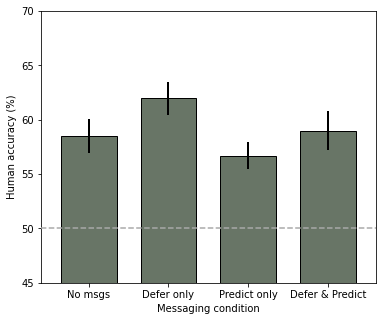

In [20]:
# @title Figure 5: Plot human accuracy for the four conditions
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
condition_labels = ['No msgs', 'Defer only', 'Predict only', 'Defer & Predict']
fig.patch.set_facecolor('white')
figure_5(
    means=fig1_means,
    errors=fig1_errors,
    labels=condition_labels,
    ax=ax,
    colours=COLOURS,
)

Difference between low and high confidence conformity: t=2.54, p=0.014


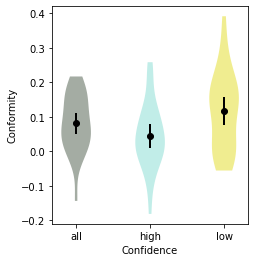

In [21]:
# @title Figure 6: Rater conformity analysis

# Compute the conformity results under different confidence conditions.
overall = get_delta_agreement(
    ConfidenceLevel.ALL,
    imagewise_df,
)
high = get_delta_agreement(
    ConfidenceLevel.HIGH,
    imagewise_df,
)
low = get_delta_agreement(
    ConfidenceLevel.LOW,
    imagewise_df,
)

violin_colours = ['#687566', '#99E1D9', '#E7E247']

# Produce Figure 6 plus associated statistics.
figure_6(
    all_conformity=overall,
    sure_conformity=high,
    unsure_conformity=low,
    colours=violin_colours,
    )

Difference : t=2.19, p=0.032


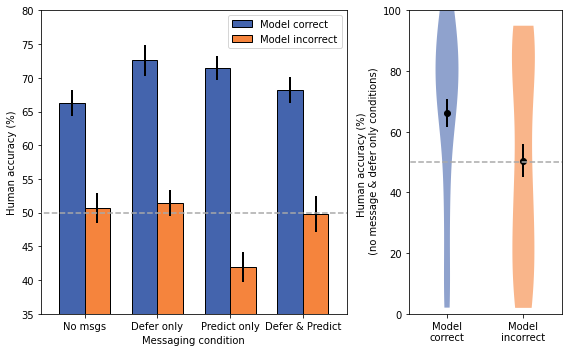

In [22]:
# @title Figure 7: Investigation of accuracy split by model correctness

fig, ax = plt.subplots(1, 2,
                       figsize=(8, 5),
                       gridspec_kw={'width_ratios': [1, 0.5]})
figure_7a(
    means=fig2_means,
    errors=fig2_errors,
    labels=condition_labels,
    ax=ax[0],
    colours=COLOURS[1:],
)
figure_7b(
    imagewise_accuracy['model_correct'],
    imagewise_accuracy['model_incorrect'],
    ax=ax[1],
    colours=COLOURS,
)
fig.patch.set_facecolor('white')
fig.tight_layout()

In [23]:
# Imagewise correlation between human likert ratings and model scores on the same images.
likert_per_image, model_score = compute_human_and_model_scores(
    data=imagewise_df,
    conditions=['NM', 'DO'],
)
coeff, p = scipy.stats.pearsonr(likert_per_image, model_score)
print(f'Correlation coefficient: {coeff:.2f}, p={p:.3f}')

Correlation coefficient: 0.27, p=0.021
